# TOTVS Data Challenge

#### Exploratory Data Analysis

Our dataset is the transaction information of many restaurant meals. In this notebook we'll try and find interesting descriptions and patterns in the data.

In [66]:
#importing relevant modules
import pandas as pd
import numpy as np
import pymongo
import pprint
import datetime as dt
import copy

from matplotlib import pyplot as plt
import seaborn as sns; sns.set_style('whitegrid')

%matplotlib inline

In [67]:
from connectionstring import connectionstring as cs
sample = pymongo.MongoClient(cs)['totvs']['sample']

In [4]:
# retrieving a random document and looking at each feature it has
doc = sample.aggregate(
   [{ '$sample': { 'size': 1 } }]
)

doc = list(doc)[0]

for k in doc.keys():
    if k != '_id':
        print('>', k, '\n')
        pprint.pprint(doc[k])
        print('\n--~--\n')

> complemento 

{'valorTotal': 110.48}

--~--

> dets 

[{'nItem': '1',
  'prod': {'indTot': '1',
           'qCom': 1.414,
           'uCom': 'KG',
           'vProd': 97.0,
           'vUnCom': 68.6,
           'xProd': 'BUFFET'}},
 {'nItem': '2',
  'prod': {'indTot': '1',
           'qCom': 1.0,
           'uCom': 'UN',
           'vProd': 4.5,
           'vUnCom': 4.5,
           'xProd': 'REFRIGERANTE'}},
 {'nItem': '3',
  'prod': {'indTot': '1',
           'qCom': 1.0,
           'uCom': 'UN',
           'vProd': 4.5,
           'vUnCom': 4.5,
           'xProd': 'REFRIGERANTE'}},
 {'nItem': '4',
  'prod': {'indTot': '1',
           'qCom': 1.0,
           'uCom': 'UN',
           'vProd': 4.5,
           'vUnCom': 4.5,
           'xProd': 'REFRIGERANTE'}}]

--~--

> emit 

{'cnpj': '01.234.567/0001-89',
 'enderEmit': {'fone': '1-650-933-4902',
               'uf': 'CA',
               'xBairro': '',
               'xLgr': '650 Castro St. unit 210',
               'xMun': 'Mounta

Initially, let's check the time interval this dataset contains, so we can start to grasp what can be further analysed.

In [23]:
grouping = {
    '$group': {
        '_id': None,
        'firstMeal': {'$min': '$ide.dhEmi'},
        'lastMeal': {'$max': '$ide.dhEmi'}
    }
}

q = sample.aggregate([
    grouping
]).next()

print('First meal: {}'.format(q['firstMeal']))
print('Last meal:  {}\n'.format(q['lastMeal']))

First meal: 2016-01-05 12:01:54
Last meal:  2016-01-23 14:56:35



We can see we have data from meals that happened during a few weeks of january in 2016. This is not a very long time series, but should be enought for us to detect a few patterns.

Before we start looking for patterns, let's quickly check signal in terms of number of meals and cost.

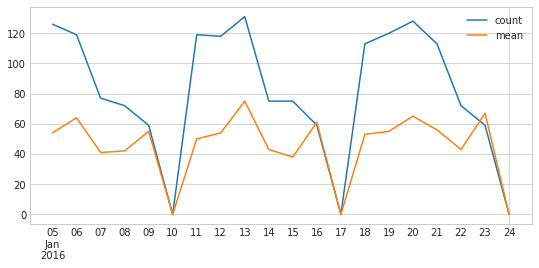

In [58]:
projecting = {
    '$project': {
        '_id': 0, 
        'dat': '$ide.dhEmi',
        'val': '$complemento.valorTotal'
    }
}

q = sample.aggregate([
    projecting
])

q = pd.DataFrame(list(q))
q = q.groupby(q.dat.dt.date)['val'].agg(['count', np.mean, np.median])
aux = pd.DataFrame(index=pd.date_range(dt.datetime(2016,1,5), dt.datetime(2016,1,24)))
q = pd.concat([aux, q], axis=1).fillna(0).astype(int)
q[['count', 'mean']].plot(figsize=(9,4)) # in this case both values are in the same scale, so as we're only exploring, we won't be two
                                         # too careful with axis labelling

The days with zero meals are sundays, when the restaurant does not open.

We can start to see the cyclical pattern this data has, even dealing with such a short time window. Also, there seems to be a stable tendency.

What we see is that generaly the begining of the week is associated with higher meals sold. Thursday sees a decline in two of the three weeks available and Friday and Saturday have the lowest turnout, despite Saturday displaying a higher average (the median behaves very closely to the mean).

Next, let's see how the meals are distributed during the days in a simple count. For now, we'll not differetiate the day of the week nor will we look at the value of the meals, which will be done in the next steps.

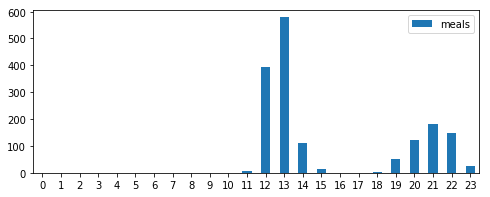

In [4]:
grouping = {
    '$group': {
        '_id': {'hour': {'$hour': '$ide.dhEmi'}},
        'meals': {'$sum': 1}
    }
}

projecting = {
    '$project': {
        '_id': 0,
        'hour': '$_id.hour',
        'meals': 1
    }
}

sorting = {
    '$sort': {
        'hour': 1
    }
}

q = sample.aggregate([
    grouping,
    projecting,
    sorting
])

q = pd.DataFrame(list(q))
q.set_index('hour', drop=True, inplace=True)
q = pd.concat([pd.DataFrame(index=range(24)), q], axis=1).fillna(0).astype(int)

q.plot(kind='bar', rot=0, figsize=(8,3))

We can see that the meals concentrate around two different moments in the day, which is fully expected. To facilitate further comparisons between these two clusters, we'll create a new variable called _refeicao_, taking two possible values: _Almoco_ and _Jantar_.

In [5]:
vals = ['Almoco', 'Jantar']
updates = []

docs = sample.aggregate([{'$project': {'hour': {'$hour': '$ide.dhEmi'}}}])
for doc in docs:
    updates.append(pymongo.UpdateOne({'_id': doc['_id']}, {'$set': {'refeicao': vals[doc['hour'] > 16]}}))
u = sample.bulk_write(updates)
print('# modified docs: {}'.format(u.modified_count))

# modified docs: 0


In [8]:
list(sample.aggregate([
    {
        '$group': {
            '_id': '$refeicao',
            'total': {'$sum': 1}
        }
    }
]))

[{'_id': 'Jantar', 'total': 530}, {'_id': 'Almoco', 'total': 1105}]

All docs nows have a _refeicao_ field and this counts make sense given our plot aboce, so it seems the operation was succesful.

Returning to the exploration of our dataset, let's examine the mean value of the meals, also by hour:

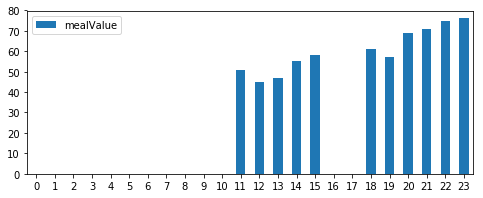

In [9]:
grouping = {
    '$group': {
        '_id': {'hour': {'$hour': '$ide.dhEmi'}},
        'mealValue': {'$avg': '$complemento.valorTotal'}
    }
}

projecting = {
    '$project': {
        '_id': 0,
        'hour': '$_id.hour',
        'mealValue': 1
    }
}

sorting = {
    '$sort': {
        'hour': 1
    }
}

q = sample.aggregate([
    grouping,
    projecting,
    sorting
])

q = pd.DataFrame(list(q))
q.set_index('hour', drop=True, inplace=True)
q = pd.concat([pd.DataFrame(index=range(24)), q], axis=1).fillna(0).astype(int)

q.plot(kind='bar', rot=0, figsize=(8,3))

It seems that the later the bill is closed, the meal cost is expected to be higher.

Let's recreate our timeseries plot, now separating by meal type:

In [ ]:
projecting = {
    '$project': {
        '_id': 0, 
        'refeicao': 1,
        'dat': '$ide.dhEmi',
        'val': '$complemento.valorTotal',
        
    }
}

q = sample.aggregate([
    projecting
])

q = pd.DataFrame(list(q)) # we'll use this DataFrame in the next few analysis.

Text(0,0.5,'Jantar')

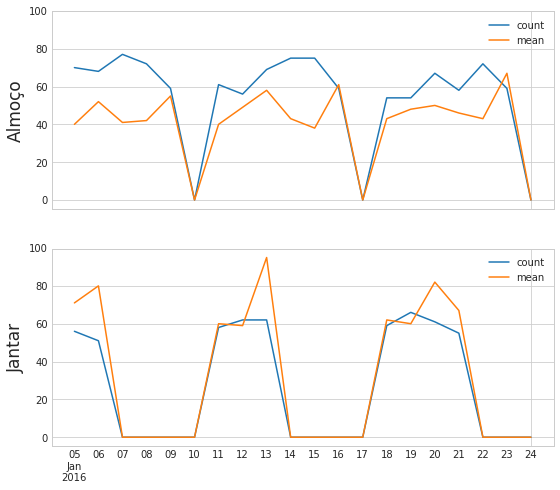

In [73]:
q_alm = copy.deepcopy(q[q.refeicao == 'Almoco']) # copying just to avoid pandas warnings of dealing with a view
q_jan = copy.deepcopy(q[q.refeicao != 'Almoco'])
q_alm = q_alm.groupby(q_alm.dat.dt.date)['val'].agg(['count', np.mean, np.median])
q_jan = q_jan.groupby(q_jan.dat.dt.date)['val'].agg(['count', np.mean, np.median])
aux = pd.DataFrame(index=pd.date_range(dt.datetime(2016,1,5), dt.datetime(2016,1,24)))
q_alm = pd.concat([aux, q_alm], axis=1).fillna(0).astype(int)
q_jan = pd.concat([aux, q_jan], axis=1).fillna(0).astype(int)

fig, ax = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(9,8))
q_alm[['count', 'mean']].plot(ax=ax[0])
ax[0].set_ylabel('Almoço', size=17)
q_jan[['count', 'mean']].plot(ax=ax[1])
ax[1].set_ylabel('Jantar', size=17)

Now we can see the reason of the higher values in the start of the week: in addition to lunch, there are also dinners. We can also see that the last Thursday available arecorded dinner, in opposition with the previous two, thus the difference observed earlier.

Also, we one more time note the mean cost is higher on dinners. Let's check this in a more detailed fashion:

In [86]:
q['weekday'] = q.dat.dt.weekday

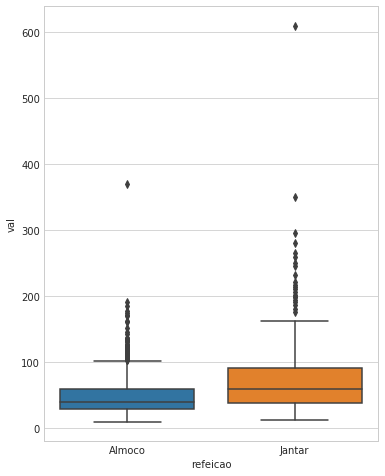

In [102]:
fig, ax = plt.subplots(figsize=(6,8))
sns.boxplot(x="refeicao", y="val", data=q, ax=ax)

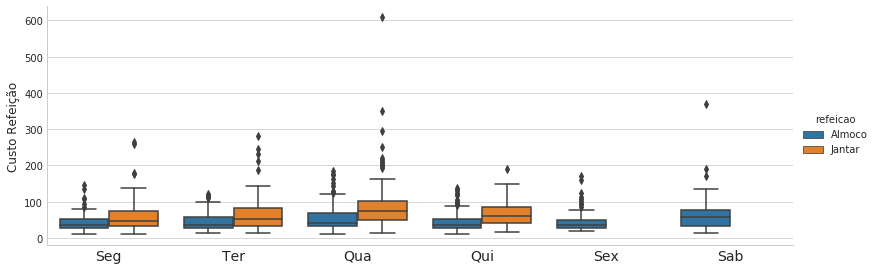

In [97]:
g = sns.factorplot(x="weekday", y="val",
                   hue="refeicao"
                   data=q, kind="box",
                   size=4, aspect=2.8);
g.set_xticklabels(['Seg', 'Ter', 'Qua', 'Qui', 'Sex', 'Sab'], size=14)
g.set_xlabels('')
g.set_ylabels('Custo Refeição', size=12)

We can see the that the same pattern of dinner being generally more expensive than lunch is repeated in every day of the week.

In [116]:
q = sample.aggregate([
    {
        '$group': {
            '_id': '$infAdic.infCpl',
            'mean_val': {'$avg': '$complemento.valorTotal'},
            'meals': {'$sum': 1}
        }
    },{
        '$sort': {'mean_val': -1}
    }
])

list(q)

[{'_id': 'Mesa 11', 'meals': 22, 'mean_val': 88.23045454545455},
 {'_id': 'Mesa 13', 'meals': 23, 'mean_val': 84.01565217391305},
 {'_id': 'Mesa 98', 'meals': 11, 'mean_val': 79.88909090909091},
 {'_id': 'Mesa 7', 'meals': 24, 'mean_val': 75.57083333333334},
 {'_id': 'Mesa 70', 'meals': 19, 'mean_val': 66.9857894736842},
 {'_id': 'Mesa 75', 'meals': 22, 'mean_val': 66.08272727272727},
 {'_id': 'Mesa 44', 'meals': 21, 'mean_val': 65.44666666666667},
 {'_id': 'Mesa 88', 'meals': 16, 'mean_val': 65.331875},
 {'_id': 'Mesa 25', 'meals': 22, 'mean_val': 65.01363636363637},
 {'_id': 'Mesa 18', 'meals': 22, 'mean_val': 64.25090909090909},
 {'_id': 'Mesa 35', 'meals': 23, 'mean_val': 63.54304347826087},
 {'_id': 'Mesa 89', 'meals': 15, 'mean_val': 63.468666666666664},
 {'_id': 'Mesa 61', 'meals': 22, 'mean_val': 62.29818181818182},
 {'_id': 'Mesa 1', 'meals': 24, 'mean_val': 62.26},
 {'_id': 'Mesa 90', 'meals': 16, 'mean_val': 62.134375},
 {'_id': 'Mesa 72', 'meals': 22, 'mean_val': 61.4968181

In [140]:
projecting = {
    '$project': {
        '_id': 0,
        'time': {
            '$add': [
                {'$multiply': [{'$hour': '$ide.dhEmi'}, 60]},
                {'$minute': '$ide.dhEmi'}
            ]
        },
        'val': '$complemento.valorTotal',
        'mesa': '$infAdic.infCpl'
    }
}

q = sample.aggregate([
    projecting
])
q = pd.DataFrame(list(q))
# q['mesa'] = q['mesa'].str.split().str.get(-1).astype(int)
q.head()

,mesa,time,val
0,Mesa 2,721,24.90
1,Mesa 1,723,92.53
2,Mesa 3,737,34.97
3,Mesa 4,738,46.23
4,Mesa 6,740,32.76


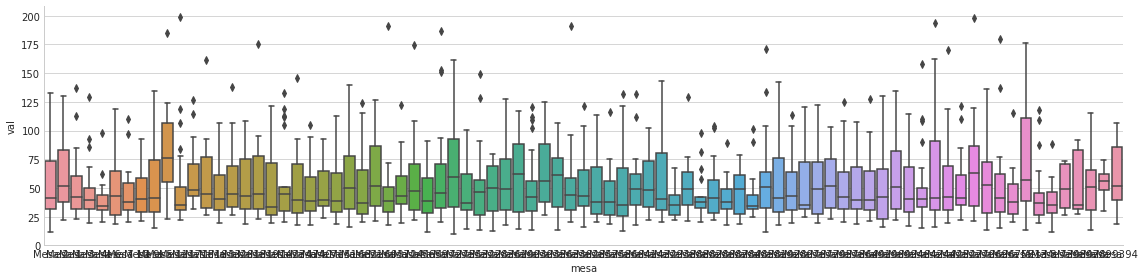

In [144]:
g = sns.factorplot(x="mesa", y="val",
#                    hue="refeicao"
                   data=q2, kind="box",
                   size=4, aspect=4);

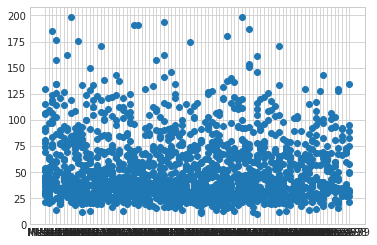

In [143]:
q2 = q[q['val'] < 200]
plt.scatter(q2.mesa, q2.val)

In [138]:
q.groupby('mesa')['val'].agg(['count', np.mean, np.median]).sort_values(by='mean')

,count,mean,median
mesa,,,
38,20,38.096000,35.505
73,17,39.184118,35.270
87,16,42.553750,37.900
82,18,43.448333,37.575
55,19,43.817368,37.860
59,20,44.223000,39.045
85,12,45.273333,34.385
10,24,45.400833,38.190
58,18,46.083333,37.530


In [121]:
projecting = {
    '$project': {
        '_id': 0,
        'itens': {'$size': '$dets'},
        'val': '$complemento.valorTotal',

    }
}

sorting = {
    '$sort': {
        'itens': -1
    }
}

a = sample.aggregate([
    projecting,
    sorting
])

list(a)

[{'itens': 10, 'val': 608.91},
 {'itens': 9, 'val': 249.95},
 {'itens': 8, 'val': 142.99},
 {'itens': 7, 'val': 349.47},
 {'itens': 7, 'val': 161.84},
 {'itens': 6, 'val': 121.43},
 {'itens': 6, 'val': 264.98},
 {'itens': 6, 'val': 140.68},
 {'itens': 6, 'val': 220.97},
 {'itens': 6, 'val': 131.81},
 {'itens': 6, 'val': 190.91},
 {'itens': 6, 'val': 121.2},
 {'itens': 5, 'val': 89.69},
 {'itens': 5, 'val': 137.28},
 {'itens': 5, 'val': 212.91},
 {'itens': 5, 'val': 232.38},
 {'itens': 5, 'val': 85.24},
 {'itens': 5, 'val': 153.18},
 {'itens': 5, 'val': 59.06},
 {'itens': 5, 'val': 170.37},
 {'itens': 5, 'val': 137.94},
 {'itens': 5, 'val': 127.95},
 {'itens': 5, 'val': 120.39},
 {'itens': 5, 'val': 83.29},
 {'itens': 5, 'val': 114.59},
 {'itens': 5, 'val': 174.51},
 {'itens': 5, 'val': 198.69},
 {'itens': 5, 'val': 88.95},
 {'itens': 5, 'val': 134.64},
 {'itens': 5, 'val': 121.11},
 {'itens': 5, 'val': 127.48},
 {'itens': 5, 'val': 100.09},
 {'itens': 5, 'val': 74.02},
 {'itens': 5, 'v

In [9]:
tips = sns.load_dataset("tips")

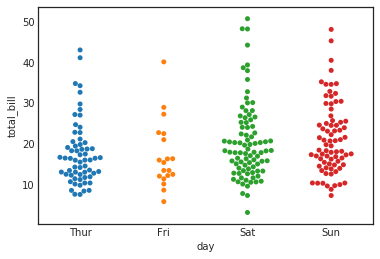

In [10]:
sns.swarmplot(x="day", y="total_bill", data=tips);

In [11]:
tips

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4
5,25.29,4.71,Male,No,Sun,Dinner,4
6,8.77,2.00,Male,No,Sun,Dinner,2
7,26.88,3.12,Male,No,Sun,Dinner,4
8,15.04,1.96,Male,No,Sun,Dinner,2
9,14.78,3.23,Male,No,Sun,Dinner,2


In [ ]:
unwinding = {
    '$unwind': '$dets'
}

matching = {
    '$match': {
        'dets.prod.xProd': 'BUFFET'
    }
}

grouping = {
    '$group': {
        '_id': {'hour': {'$hour': '$ide.dhEmi'}},
        'mealValue': {'$avg': '$dets.prod.vUnCom'}
    }
}

projecting = {
    '$project': {
        '_id': 0,
        'hour': '$_id.hour',
        'mealValue': 1
    }
}

sorting = {
    '$sort': {
        'hour': 1
    }
}

q = sample.aggregate([
    unwinding,
    matching,
    grouping,
    projecting,
    sorting
])

In [ ]:

grouping = {
    '$group': {
        '_id': {'hour': {'$hour': '$ide.dhEmi'}},
        'meals': {'$avg': '$complemento.valorTotal'}
    }
}

projecting = {
    '$project': {
        '_id': 0,
        'hour': '$_id.hour',
        'meals': 1
    }
}

sorting = {
    '$sort': {
        'hour': 1
    }
}

a = sample.aggregate([
    grouping,
    projecting,
    sorting
])

pd.DataFrame(list(a))

In [19]:
# we'll add a new field to the data, making it simpler to filter by kind of meal ('Almoço' or 'Jantar')
docs = []
for doc in sample.aggregate([{'$project': {'data': '$ide.dhEmi', 'hora': {'$hour': '$ide.dhEmi'}}}]):
    print(doc)
    break

{'_id': ObjectId('5a96d219c873dee19ccc462a'), 'data': datetime.datetime(2016, 1, 5, 12, 3, 52), 'hora': 12}


We can see we have data regarding how much the meal cost, discriminated by the food and drinks. What we unfortunely do not have is customer information, as it could be very important for predicting amount spent for example.

Let's check some descriptive statistics of our dataset.

In [12]:
# valorTotal
sample.aggregate([
    {
        '$group': {
            '_id': None,
            'meanValue': {'$avg': '$complemento.valorTotal'},
            'stdDeviation': {'$stdDevPop': '$complemento.valorTotal'},
            'maxValue': {'$max': '$complemento.valorTotal'},
            'minValue': {'$min': '$complemento.valorTotal'}
        }
    },{
        '$project': {
            '_id': 0
        }
    }
]).next()

{'maxValue': 608.91,
 'meanValue': 55.50417125382263,
 'minValue': 9.74,
 'stdDeviation': 39.20546729763231}

In [14]:
# todos valores
v = sample.aggregate([
    {
        '$project': {
            '_id': 0,
            'valor': '$complemento.valorTotal',
            'timestamp': '$ide.dhEmi'
        }
    }
])

v = pd.DataFrame(list(v))
v

,timestamp,valor
0,2016-01-05 12:03:52,92.53
1,2016-01-05 12:01:54,24.90
2,2016-01-05 12:17:50,34.97
3,2016-01-05 12:18:35,46.23
4,2016-01-05 12:20:00,32.76
5,2016-01-05 12:22:16,57.11
6,2016-01-05 12:22:57,36.19
7,2016-01-05 12:23:25,32.37
8,2016-01-05 12:16:40,57.86
9,2016-01-05 12:35:11,34.17
